# Causal Inference
## Задание CI.2


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

---


**Баллы за задание:**

* Задача 1 — 10 баллов
* Задача 2 — 20 баллов
* Задача 3 — 50 баллов
* Задача 4 — 50 баллов


In [134]:
# Bot check

# HW_ID: ds_ci2
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [135]:
import warnings

import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import graphviz as gr
import scipy.stats as sps

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from torch import nn
import torch
from tqdm.notebook import tqdm
from causalinference import CausalModel

from joblib import Parallel, delayed

sns.set(font_scale=1.3, palette="Set2", style="whitegrid")
warnings.filterwarnings("ignore")

---
### Задача 1.
Случайные величины $X$, $Y$ и $Z$ имеют следующее распределение.

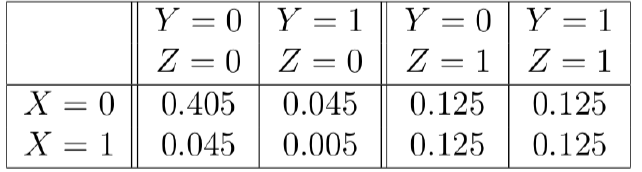

Являются ли величины $X$ и $Y$
* независимыми;
* условно независимыми по $Z$?

Можно использовать питон как калькулятор.

1) Независимость

Проверим независимость при помощи формулы полной вероятности

\begin{aligned}
P(X = 0, Y = 0) &= 0.405 + 0.125 = 0.53 \\
P(X = 0) \cdot P(Y = 0) &= (0.405 + 0.045 + 0.125 + 0.125) \cdot (0.450 + 0.250) = 0.7 \cdot 0.7 = 0.49
\end{aligned}

**Значит X и Y не независимы.**

2) Условная независимость

\begin{aligned}
&P(X=x, Y=y | Z = z) = \frac{P(X=x, Y=y, Z = z)}{P(Z = z)} \\
&P(X = x | Z = z)  = \frac{P(X = x, Z = z)}{P(Z = z)}
\end{aligned}


Напишем код для автоматической проверки

In [136]:
index = ['X = 0', 'X = 1']

columns = [
    'Y = 0, Z = 0',
    'Y = 1, Z = 0',
    'Y = 0, Z = 1',
    'Y = 1, Z = 1'
]

data = [
    [0.405, 0.045, 0.125, 0.125],  # X = 0
    [0.045, 0.005, 0.125, 0.125]   # X = 1
]

df = pd.DataFrame(data, index=index, columns=columns)

df

,"Y = 0, Z = 0","Y = 1, Z = 0","Y = 0, Z = 1","Y = 1, Z = 1"
X = 0,0.405,0.045,0.125,0.125
X = 1,0.045,0.005,0.125,0.125


In [137]:
def get_probs(x, y, z, df):
    x_str = f'X = {x}'
    y_z_str = f'Y = {y}, Z = {z}'

    Z_z = df[f"Y = 0, Z = {z}"].sum() + df[f"Y = 1, Z = {z}"].sum()

    X_x_Y_y_Z_z = df.loc[x_str, y_z_str] / Z_z
    print(f"P(X = {x}, Y = {y}| Z = {z}) = {X_x_Y_y_Z_z:.3f}")

    X_x_cond_Z_z = (df.loc[x_str, f"Y = 0, Z = {z}"] + df.loc[x_str, f"Y = 1, Z = {z}"]) / Z_z

    Y_y_cond_Z_z = (df.loc['X = 0', y_z_str] + df.loc['X = 1', y_z_str]) / Z_z

    print(f"P(X = {x}| Z = {z}) * P(Y = {y}| Z = {z}) = {X_x_cond_Z_z * Y_y_cond_Z_z:.3f}")

    if abs(X_x_Y_y_Z_z - (X_x_cond_Z_z * Y_y_cond_Z_z)) < 1e-9:
        print("Независимы")
    else:
        print("Зависимы")

In [138]:
for i in range(2):
    for j in range(2):
        for k in range(2):
            get_probs(i, j, k, df)

P(X = 0, Y = 0| Z = 0) = 0.810
P(X = 0| Z = 0) * P(Y = 0| Z = 0) = 0.810
Независимы
P(X = 0, Y = 0| Z = 1) = 0.250
P(X = 0| Z = 1) * P(Y = 0| Z = 1) = 0.250
Независимы
P(X = 0, Y = 1| Z = 0) = 0.090
P(X = 0| Z = 0) * P(Y = 1| Z = 0) = 0.090
Независимы
P(X = 0, Y = 1| Z = 1) = 0.250
P(X = 0| Z = 1) * P(Y = 1| Z = 1) = 0.250
Независимы
P(X = 1, Y = 0| Z = 0) = 0.090
P(X = 1| Z = 0) * P(Y = 0| Z = 0) = 0.090
Независимы
P(X = 1, Y = 0| Z = 1) = 0.250
P(X = 1| Z = 1) * P(Y = 0| Z = 1) = 0.250
Независимы
P(X = 1, Y = 1| Z = 0) = 0.010
P(X = 1| Z = 0) * P(Y = 1| Z = 0) = 0.010
Независимы
P(X = 1, Y = 1| Z = 1) = 0.250
P(X = 1| Z = 1) * P(Y = 1| Z = 1) = 0.250
Независимы


**С.В. условно независимы**

---
### Задача 2.

На рисунке дан ориентированный граф.
* В предположении, что он задает марковское распределение, выпишите факторизацию плотности, см. определение марковского распределения.
* Перечислите все коллайдры.
* Докажите независимость $X$ и $Z_j$.

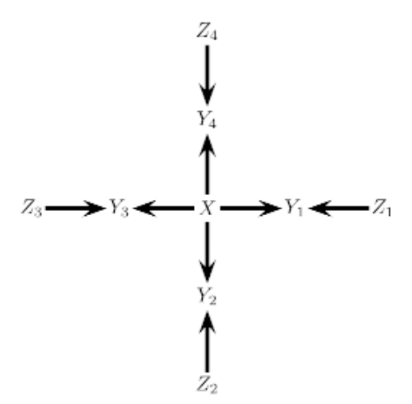

1) Распределение на графе:

$$
P(X, Y_1, Y_2, Y_3, Y_4, Z_1, Z_2, Z_3, Z_4) = P(X) \cdot \prod\limits_{i=1}^{4} P(Y_i|X, Z_i) \cdot \prod\limits_{i=1}^{4} P(Z_i)
$$

2) Коллайдеры: $\{Y_i | i \in \overline{1, 4}\}$

3) Рассмотрим $X$ и $Z_i$. Они разделимы по $\emptyset$, так как любой путь содержит коллайдер в $Y_i$ и он не лежит в $\emptyset$

Значит $X$ и $Z_i$ независимы.

---
### Задача 3.

Вернемся к данным задачи AB.3.1, где, как мы ранее выяснили, экспериментальная выборка выбиралась не рандомизировано. Загрузите данные.

In [139]:
data = pd.read_csv('hw_ab3_task1.csv').drop(["Unnamed: 0"], axis=1)

data.head()

,gender,OS,month1,month2,month3,month4,month5,month6,month7,month8,...,month10,month11,month12,month13,month14,month15,month16,month17,month18,b_group
0,woman,Android,0.000000,0.000000,1260.801227,1245.777408,0.000000,0.000000,1381.093860,1237.133907,...,1110.443064,0.000000,0.000000,0.000000,0.000000,1362.797130,1555.238727,0.000000,0.000000,no
1,man,Android,2142.521523,1821.295907,1832.895312,1646.448173,0.000000,2154.948644,1912.998501,1795.471291,...,0.000000,2253.871388,2526.126916,2861.138746,3068.924457,3384.232538,0.000000,0.000000,0.000000,yes
2,man,iOS,2064.105816,0.000000,0.000000,1454.148004,1821.118092,1917.801237,2188.827425,0.000000,...,1605.922754,0.000000,0.000000,1672.408077,1403.642040,1094.256738,962.442222,0.000000,1483.007220,no
3,woman,Android,1177.158341,1311.983158,0.000000,1302.464341,0.000000,0.000000,1479.573874,1356.655637,...,1713.852207,0.000000,0.000000,0.000000,1025.802676,1020.161834,949.921959,1029.725858,866.403692,yes
4,man,iOS,0.000000,2603.825002,2350.628045,2061.660828,1686.922097,0.000000,2720.638298,2541.299625,...,1920.793567,1879.833618,1991.184786,0.000000,2792.189328,2498.976500,2121.921368,2130.713432,2035.514926,no


Посчитайте выборочные средние за последний месяц, а также примените обычный t-test для сравнения этих средних.

In [140]:
control_mean = data.loc[data['b_group'] == "no", "month18"].mean()
pilot_mean = data.loc[data['b_group'] == "yes", "month18"].mean()

print(f"Контрольная группа: {control_mean:.1f}")
print(f"Экспериментальная группа: {pilot_mean:.1f}")

Контрольная группа: 965.5
Экспериментальная группа: 1079.0


Применим обычный t-test

In [141]:
result, p_val = sps.ttest_ind(
    data.loc[data['b_group'] == "yes", "month18"],
    data.loc[data['b_group'] == "no", "month18"],
)

print(f"t-statistic: { result / control_mean:.3f}")
print(f"p-value: {p_val:.3f}")
if p_val < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не отвергаем нулевую гипотезу")

t-statistic: 0.005
p-value: 0.000
Отвергаем нулевую гипотезу


Но мы же знаем, что группы несопоставимы. Это означает, что нужно применять методы causal inference. Постройте и визуализируйте граф причинно-следственных связей по представленным в данных признакам. Чтобы не раздувать граф, среди месяцев достаточно рассмотреть только 3 последних.

*Примечание.* Граф может не сохраниться в ноутбуке. Сделайте скриншот и прикрепите картинку к ноутбуку.

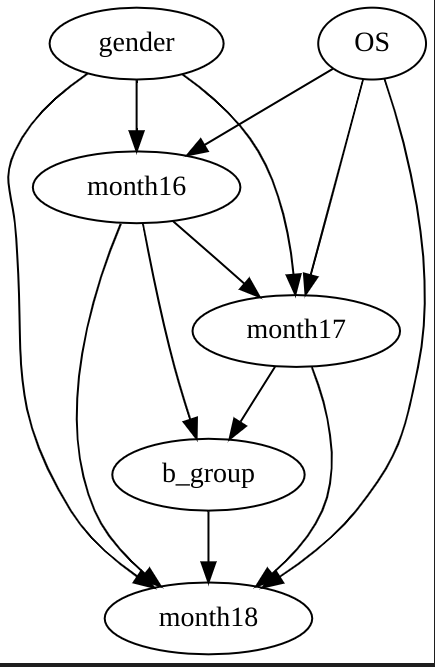

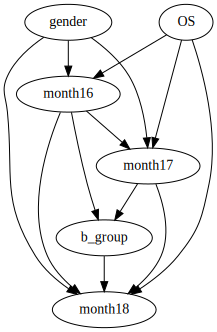

In [142]:
g = gr.Digraph()
g.edge("month17", "month18"),
g.edge("month16", "month17"),
g.edge("month16", "month18"),

g.edge("gender", "month16"),
g.edge("gender", "month17"),
g.edge("gender", "month18"),

g.edge("OS", "month16"),
g.edge("OS", "month17"),
g.edge("OS", "month18"),

g.edge("month17", "b_group"),
g.edge("month16", "b_group"),
g.edge("b_group", "month18"),


g

Постройте оценки propensity score с помощью логистической регрессии. Визуализируйте гистограмму полученных оценок для двух выборок. Можно ли по ней говорить о смещенности групп?

*Указание.* Не стоит брать больше 3-5 месяцев в качестве признаков.

In [143]:
data["gender_int"] = data["gender"].map({"woman": 0, "man": 1})
data["b_group_int"] = data["b_group"].map({"no": 0, "yes": 1})
data["OS_int"] = data["OS"].map({"iOS": 0, "Android": 1})

In [150]:
T = "b_group_int"
Y = "month18"
X = ["month17", "month16", "month15", "month14", "gender_int", "OS_int"]

ps_model = LogisticRegression(C=1e6).fit(data[X], data[T])

data_ps_logistic = data.assign(
    propensity_score=ps_model.predict_proba(data[X])[:, 1]
)

data_ps_logistic[["month18", "b_group_int", "propensity_score"]].head()

,month18,b_group_int,propensity_score
0,0.000000,0,0.073321
1,0.000000,1,0.060767
2,1483.007220,0,0.066293
3,866.403692,1,0.099365
4,2035.514926,0,0.103407


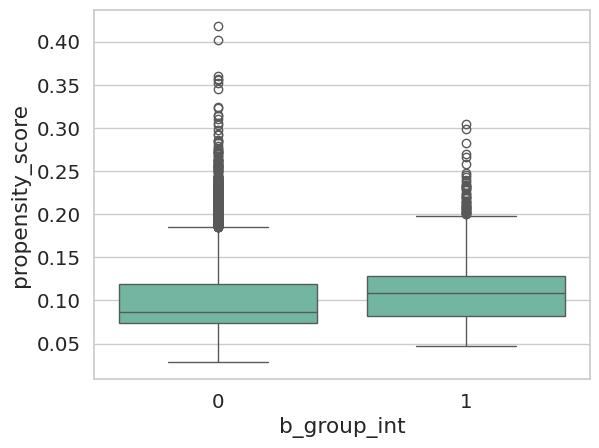

In [151]:
sns.boxplot(x="b_group_int", y="propensity_score", data=data_ps_logistic)
plt.show()

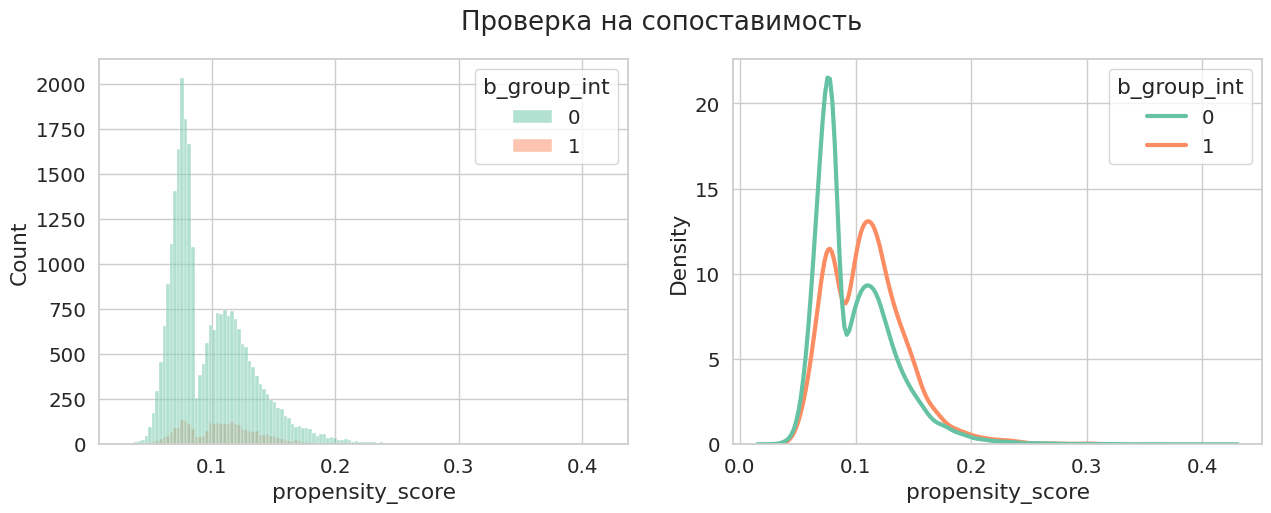

In [152]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(data=data_ps_logistic, x="propensity_score", hue="b_group_int")
plt.subplot(122)
sns.kdeplot(data=data_ps_logistic, x="propensity_score", hue="b_group_int", lw=3, common_norm=False)
plt.suptitle("Проверка на сопоставимость")
plt.show();

Да можно, ведь propensity_score отражает шанс попасть в тритмент 

Мы видим смещенность групп на плотности распределения в сторону теста.

Посчитайте "раздутый" размер каждой из групп на основе весов, определяемых с помощью propensity score.

In [ ]:
weight_t = 1 / data_ps_logistic.query("b_group_int==1")["propensity_score"]
weight_nt = 1 / (1 - data_ps_logistic.query("b_group_int==0")["propensity_score"])

print("Размер исходной выборки:", data.shape[0])
print("Размер раздутой тестовой выборки:", sum(weight_t))
print("Размер раздутой контрольной выборки:", sum(weight_nt))

Размер исходной выборки: 30000
Размер раздутой тестовой выборки: 29695.946246882864
Размер раздутой контрольной выборки: 30006.035268658135


In [ ]:
def run_ps(df, X, T, y):
    """
    Обучает логистическую регрессию для оценки propensity_score,
    вычисляет веса и получает оценку ATE

    df -- данные
    X -- список признаков
    T -- признак-тритмент
    y -- признак-таргет
    """

    ps = (
        LogisticRegression(C=1e6, max_iter=10000)
        .fit(df[X], df[T])
        .predict_proba(df[X])[:, 1]
    )

    weight = (df[T] - ps) / (ps * (1 - ps))

    return np.mean(weight * df[y])

Наконец, посчитайте оценку ATE с помощью этих весов. Постройте также доверительный интервал, используя бутстреп.

In [ ]:
weight = (data_ps_logistic["b_group_int"] - data_ps_logistic["propensity_score"]) / (
    data_ps_logistic["propensity_score"] * (1 - data_ps_logistic["propensity_score"])
)

y1 = sum(
    data_ps_logistic.query("b_group_int==1")["month18"] * weight_t
) / len(data)
y0 = sum(
    data_ps_logistic.query("b_group_int==0")["month18"] * weight_nt
) / len(data)

ate = np.mean(weight * data_ps_logistic["month18"])

print(f"mean С1 = {y1:.3f}")
print(f"mean С0 = {y0:.3f}")
print(f"ATE = {ate:.3f}")

mean С1 = 949.199
mean С0 = 982.965
ATE = -33.766


In [ ]:
bootstrap_sample = 1000

ates = Parallel(n_jobs=4)(
    delayed(run_ps)(data.sample(frac=1, replace=True), X, T, Y)
    for _ in tqdm(range(bootstrap_sample))
)
ates = np.array(ates)

print(f"ATE = {ates.mean():.3f}")
print(
    f"95% C.I. = ({np.percentile(ates, 2.5):.3f}, {np.percentile(ates, 97.5):.3f})"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

ATE = -34.339
95% C.I. = (-73.005, 4.952)


Повторите все эти действия для какой-либо другой ML-модели, которая умеет предсказывать вероятности класса, например, можно взять градиентный бустинг. Сравните результаты.

In [ ]:
ps_model = nn.Sequential(
    nn.Linear(data[X].shape[1], 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(ps_model.parameters(), lr=1e-1)

X_train = torch.tensor(data[X].values, dtype=torch.float32)
T_train = torch.tensor(data[T].values, dtype=torch.float32).unsqueeze(1)

for epoch in tqdm(range(31)): 
    optimizer.zero_grad()
    outputs = ps_model(X_train)
    loss = criterion(outputs, T_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))


  0%|          | 0/31 [00:00<?, ?it/s]

epoch 0, loss 0.6816710829734802
epoch 10, loss 0.47828397154808044
epoch 20, loss 0.3544175922870636
epoch 30, loss 0.3315575420856476


In [ ]:
data_ps_network = data.assign(
    propensity_score=ps_model(X_train).detach().numpy()
)

data_ps_network[["month18", "b_group_int", "propensity_score"]].head()

,month18,b_group_int,propensity_score
0,0.000000,0,0.084908
1,0.000000,1,0.007262
2,1483.007220,0,0.072202
3,866.403692,1,0.131411
4,2035.514926,0,0.096498


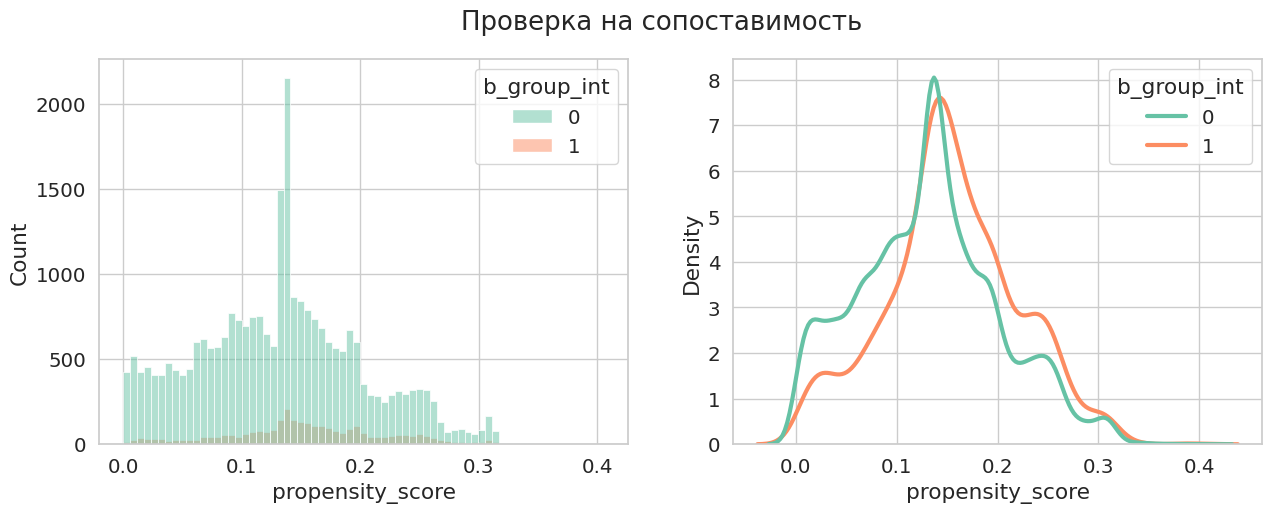

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(data=data_ps_network, x="propensity_score", hue="b_group_int")
plt.subplot(122)
sns.kdeplot(data=data_ps_network, x="propensity_score", hue="b_group_int", lw=3, common_norm=False)
plt.suptitle("Проверка на сопоставимость")
plt.show();

In [ ]:
weight_t = 1 / data_ps_network.query("b_group_int==1")["propensity_score"]
weight_nt = 1 / (1 - data_ps_network.query("b_group_int==0")["propensity_score"])

print("Размер исходной выборки:", data.shape[0])
print("Размер раздутой тестовой выборки:", sum(weight_t))
print("Размер раздутой контрольной выборки:", sum(weight_nt))

Размер исходной выборки: 30000
Размер раздутой тестовой выборки: 33375.37413620949
Размер раздутой контрольной выборки: 31294.547981262207


In [ ]:
weight = (data_ps_network["b_group_int"] - data_ps_network["propensity_score"]) / (
    data_ps_network["propensity_score"] * (1 - data_ps_network["propensity_score"])
)

y1 = sum(
    data_ps_network.query("b_group_int==1")["month18"] * weight_t
) / len(data)
y0 = sum(
    data_ps_network.query("b_group_int==0")["month18"] * weight_nt
) / len(data)

ate = np.mean(weight * data_ps_network["month18"])

print(f"mean С1 = {y1:.3f}")
print(f"mean С0 = {y0:.3f}")
print(f"ATE = {ate:.3f}")

mean С1 = 1182.098
mean С0 = 1027.613
ATE = 154.485


In [ ]:
def run_ps_ml(df, X, T, y, use_tqdm=False):
    """
    Обучает нейросеть для оценки propensity score,
    вычисляет веса и получает ATE, а также условные средние по группам

    df -- DataFrame с данными
    X -- список признаков
    T -- название колонки с тритментом (строка)
    y -- название колонки с таргетом (строка)
    use_tqdm -- использовать ли прогресс-бар
    """
    # Модель
    ps_model = nn.Sequential(
        nn.Linear(df[X].shape[1], 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Linear(128, 512),
        nn.ReLU(),
        nn.BatchNorm1d(512),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Linear(128, 1),
        nn.Sigmoid(),
    )

    # Обучение
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(ps_model.parameters(), lr=1e-1)

    X_train = torch.tensor(df[X].values, dtype=torch.float32)
    T_train = torch.tensor(df[T].values, dtype=torch.float32).unsqueeze(1)

    iterator = tqdm(range(31)) if use_tqdm else range(31)
    for epoch in iterator:
        optimizer.zero_grad()
        outputs = ps_model(X_train)
        loss = criterion(outputs, T_train)
        loss.backward()
        optimizer.step()
        # if (epoch % 10 == 0) and (not use_tqdm):
        #     print(f"epoch {epoch}, loss {loss.item():.4f}")

    # Предсказания propensity score
    ps = ps_model(X_train).detach().numpy()
    df_ps = df.copy()
    df_ps["propensity_score"] = ps

    # Вычисление весов
    t = df_ps[T].values.reshape(-1, 1)
    w = (t - ps) / (ps * (1 - ps))

    df_ps["weight"] = w

    # ATE
    ate = np.mean(df_ps["weight"] * df_ps[y])

    return ate


In [ ]:
bootstrap_sample = 10

ates = [
    run_ps_ml(data.sample(frac=1, replace=True), X, T, Y, use_tqdm=False)
    for _ in tqdm(range(bootstrap_sample))
]
ates = np.array(ates)

print(f"ATE = {ates.mean():.3f}")
print(
    f"95% C.I. = ({np.percentile(ates, 2.5):.3f}, {np.percentile(ates, 97.5):.3f})"
)

  0%|          | 0/10 [00:00<?, ?it/s]

ATE = 166.814
95% C.I. = (-316.965, 1060.316)


Мы видим, что обе модели видят перекос в распределениях. 

Тем не менее, мы видим, что полученные с их помощью оценки ATE отличаются. Кажется, что нейронная сеть дает лучшее предсказание, так как в действительности тестовые клиенты начинают приносить меньше прибыли.

Наконец, оцените ATE с помощью библиотеки causalinference методами propensity score matching и propensity score weighting. Сравните резульаты.

*Примечание.* Может случится `RecursionError`. В таком случае нужно увеличить лимит рекурсии:
```
import sys
sys.setrecursionlimit(10000)
```

propensity score matching для данных полученных при помощи логистической регрессии и нейросети

In [ ]:
cm = CausalModel(
    # таргет
    Y=data_ps_logistic["month18"].values,
    # тритмент
    D=data_ps_logistic["b_group_int"].values,
    # признак - propensity score
    X=data_ps_logistic[["propensity_score"]].values,
)

# propensity score matching
cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE    -17.656     35.158     -0.502      0.616    -86.566     51.254
           ATC    -17.071     36.666     -0.466      0.642    -88.937     54.795
           ATT    -22.927     37.530     -0.611      0.541    -96.485     50.631



In [ ]:
cm = CausalModel(
    # таргет
    Y=data_ps_network["month18"].values,
    # тритмент
    D=data_ps_network["b_group_int"].values,
    # признак - propensity score
    X=data_ps_network[["propensity_score"]].values,
)

# propensity score matching
cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     19.862     37.301      0.532      0.594    -53.248     92.971
           ATC     18.228     38.816      0.470      0.639    -57.852     94.308
           ATT     34.567     40.392      0.856      0.392    -44.601    113.735



propensity weighting score

In [ ]:
data_with_categ = data[["month18", "b_group_int", *X]].astype(float)

cm = CausalModel(
    # таргет
    Y=data_with_categ["month18"].values,
    # тритмент
    D=data_with_categ["b_group_int"].values,
    # признаки
    X=data_with_categ[X].values,
)

# Оцениваем propensity score
cm.est_propensity_s()
# propensity_score weighting
cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     56.130     27.229      2.061      0.039      2.761    109.499



In [ ]:
cm.trim_s()

cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     47.087     26.054      1.807      0.071     -3.979     98.154



**Выводы**

Мы видим, что ATE, полученное при помощи нейросети, сопоставим с оценками, полученными при помощи propensity weighting score. Причем с учетом того, что pvalue < 0.05, мы можем говорить о верности нашей оценки.

Также заметим, что результат полученный при помощи propensity score matching и линейной регресии сопоставимы.

---
### Задача 4.

Загрузите <a href="https://github.com/robjellis/lalonde">данные</a> об исследовании влияния эффективности программы профессиональной переподготовки по отношению к реальному заработку человека через пару лет после завершения программы (в 1978). Данные также содержат несколько демографических показателей &mdash; возраст, раса, академическое образование и предыдущий заработок.

Повторите для этих данных исследование предыдущей задачи.

In [ ]:
data = pd.read_csv('lalonde/lalonde_data.csv')
data.head()

,ID,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [ ]:
numerical_features = ["treat", "age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]

Посмотрим на доли в группах

In [ ]:
data[numerical_features].groupby("treat").mean().round(3)

,age,educ,black,hispan,married,nodegree,re74,re75
treat,,,,,,,,
0,28.030,10.235,0.203,0.142,0.513,0.597,5619.237,2466.484
1,25.816,10.346,0.843,0.059,0.189,0.708,2095.574,1532.055


Видим, что все кроме возраста и образования влияет на тритмент.

In [ ]:
control_mean = data.loc[data['treat'] == 0, "re78"].mean()
pilot_mean = data.loc[data['treat'] == 1, "re78"].mean()

print(f"Контрольная группа: {control_mean:.1f}")
print(f"Экспериментальная группа: {pilot_mean:.1f}")

Контрольная группа: 6984.2
Экспериментальная группа: 6349.1


Построим граф причинно-следственных связей

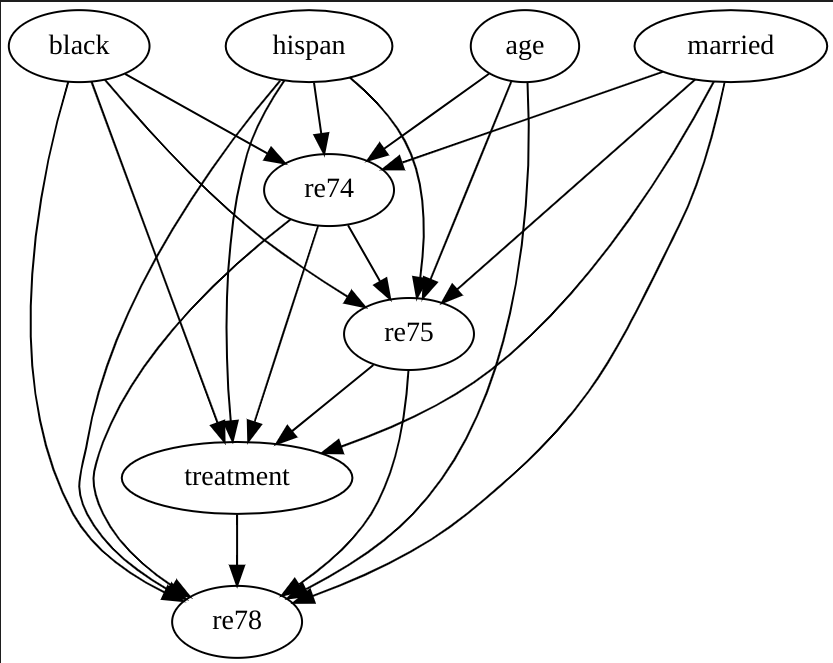

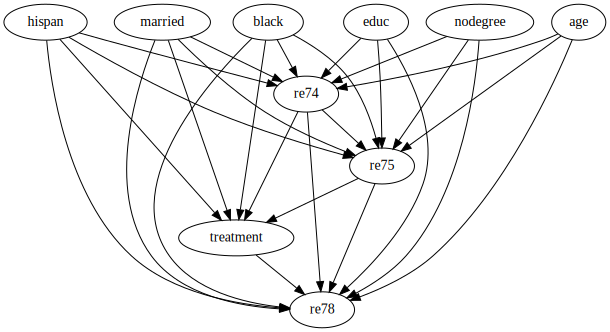

In [ ]:
g = gr.Digraph()

g.edge("treatment", "re78")


g.edge("re74", "re75")
g.edge("re74", "re78")
g.edge("re75", "re78")

g.edge("re74", "treatment")
g.edge("re75", "treatment")
g.edge("black", "treatment")
g.edge("hispan", "treatment")
g.edge("married", "treatment")

g.edge("black", "re74")
g.edge("hispan", "re74")
g.edge("married", "re74")
g.edge("black", "re75")
g.edge("hispan", "re75")
g.edge("married", "re75")

g.edge("age", "re74")
g.edge("age", "re75")
g.edge("age", "re78")

g.edge("educ", "re74")
g.edge("educ", "re75")
g.edge("educ", "re78")

g.edge("nodegree", "re74")
g.edge("nodegree", "re75")
g.edge("nodegree", "re78")


g.edge("black", "re78")
g.edge("hispan", "re78")
g.edge("married", "re78")

g

1) Логистическая регрессия

In [ ]:
T = "treat"
Y = "re78"
X = ["re74", "re75", "age",  "black", "hispan", "married", "educ", "nodegree"]

ps_model = LogisticRegression(C=1e-3, fit_intercept=True).fit(data[X], data[T])

data_ps_logistic = data.assign(
    propensity_score=ps_model.predict_proba(data[X])[:, 1]
)

data_ps_logistic[["re78", "treat", "propensity_score"]].head()

,re78,treat,propensity_score
0,9930.0460,1,0.372625
1,3595.8940,1,0.401123
2,24909.4500,1,0.394201
3,7506.1460,1,0.404253
4,289.7899,1,0.395876


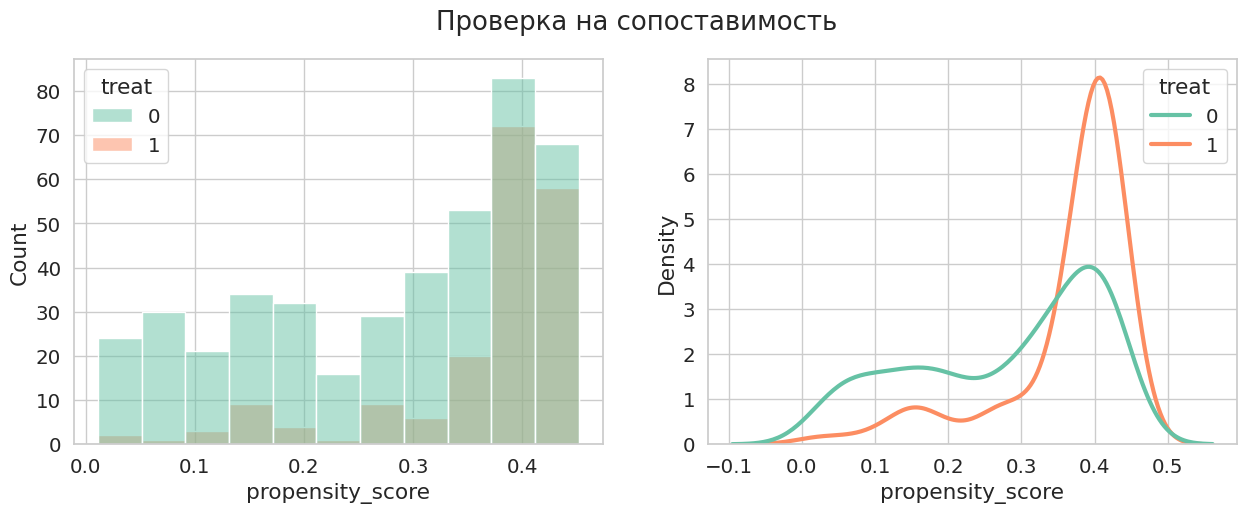

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(data=data_ps_logistic, x="propensity_score", hue="treat")
plt.subplot(122)
sns.kdeplot(data=data_ps_logistic, x="propensity_score", hue="treat", lw=3, common_norm=False)
plt.suptitle("Проверка на сопоставимость")
plt.show();

Видим явное смещение, а также часть propensity_score равна 0, что не очень хорошо.

In [ ]:
weight_t = 1 / data_ps_logistic.query("treat==1")["propensity_score"]
weight_nt = 1 / (1 - data_ps_logistic.query("treat==0")["propensity_score"])

print("Размер исходной выборки:", data.shape[0])
print("Размер раздутой тестовой выборки:", sum(weight_t))
print("Размер раздутой контрольной выборки:", sum(weight_nt))

Размер исходной выборки: 614
Размер раздутой тестовой выборки: 523.3965031092705
Размер раздутой контрольной выборки: 647.2503779296463


In [ ]:
weight = (data_ps_logistic["treat"] - data_ps_logistic["propensity_score"]) / (
    data_ps_logistic["propensity_score"] * (1 - data_ps_logistic["propensity_score"])
)

y1 = sum(
    data_ps_logistic.query("treat==1")["re78"] * weight_t
) / len(data)
y0 = sum(
    data_ps_logistic.query("treat==0")["re78"] * weight_nt
) / len(data)

ate = np.mean(weight * data_ps_logistic["re78"])

print(f"mean С1 = {y1:.3f}")
print(f"mean С0 = {y0:.3f}")
print(f"ATE = {ate:.3f}")

mean С1 = 5770.901
mean С0 = 6635.796
ATE = -864.895


In [ ]:
bootstrap_sample = 100

ates = Parallel(n_jobs=4)(
    delayed(run_ps)(data.sample(frac=1, replace=True), X, T, Y)
    for _ in tqdm(range(bootstrap_sample))
)
ates = np.array(ates)

print(f"ATE = {ates.mean():.3f}")
print(
    f"95% C.I. = ({np.percentile(ates, 2.5):.3f}, {np.percentile(ates, 97.5):.3f})"
)

  0%|          | 0/100 [00:00<?, ?it/s]

ATE = -643.970
95% C.I. = (-2242.038, 792.672)


In [ ]:
ps_model = nn.Sequential(
    nn.Linear(data[X].shape[1], 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(ps_model.parameters(), lr=1e-1)

X_train = torch.tensor(data[X].values, dtype=torch.float32)
T_train = torch.tensor(data[T].values, dtype=torch.float32).unsqueeze(1)

for epoch in tqdm(range(51)):
    optimizer.zero_grad()
    outputs = ps_model(X_train)
    loss = criterion(outputs, T_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print("epoch {}, loss {}".format(epoch, loss.item()))

  0%|          | 0/51 [00:00<?, ?it/s]

epoch 0, loss 0.6890095472335815
epoch 10, loss 0.5167569518089294
epoch 20, loss 0.5048864483833313
epoch 30, loss 0.4582994282245636
epoch 40, loss 0.44627857208251953
epoch 50, loss 0.4220309555530548


In [ ]:
data_ps_network = data.assign(
    propensity_score=ps_model(X_train).detach().numpy()
)

data_ps_network[["re78", "treat", "propensity_score"]].head()

,re78,treat,propensity_score
0,9930.0460,1,0.830024
1,3595.8940,1,0.745808
2,24909.4500,1,0.882786
3,7506.1460,1,0.893090
4,289.7899,1,0.903968


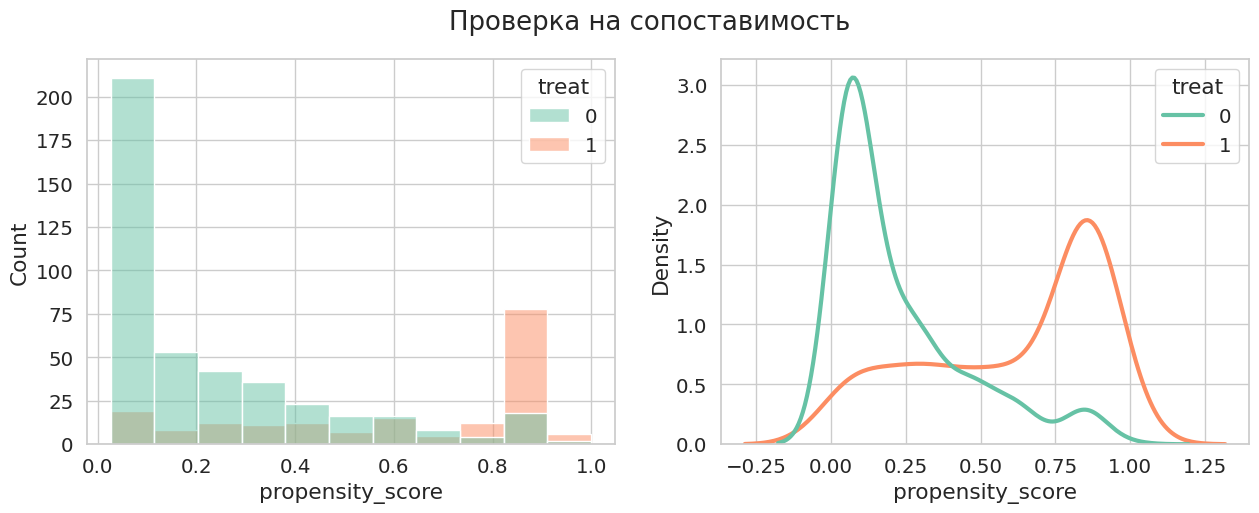

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.histplot(data=data_ps_network, x="propensity_score", hue="treat")
plt.subplot(122)
sns.kdeplot(data=data_ps_network, x="propensity_score", hue="treat", lw=3, common_norm=False)
plt.suptitle("Проверка на сопоставимость")
plt.show();

In [ ]:
weight_t = 1 / data_ps_network.query("treat==1")["propensity_score"]
weight_nt = 1 / (1 - data_ps_network.query("treat==0")["propensity_score"])

print("Размер исходной выборки:", data.shape[0])
print("Размер раздутой тестовой выборки:", sum(weight_t))
print("Размер раздутой контрольной выборки:", sum(weight_nt))

Размер исходной выборки: 614
Размер раздутой тестовой выборки: 704.7424153089523
Размер раздутой контрольной выборки: 814.8642543554306


In [ ]:
weight = (data_ps_network["treat"] - data_ps_network["propensity_score"]) / (
    data_ps_network["propensity_score"] * (1 - data_ps_network["propensity_score"])
)

y1 = sum(
    data_ps_network.query("treat==1")["re78"] * weight_t
) / len(data)
y0 = sum(
    data_ps_network.query("treat==0")["re78"] * weight_nt
) / len(data)

ate = np.mean(weight * data_ps_network["re78"])

print(f"mean С1 = {y1:.3f}")
print(f"mean С0 = {y0:.3f}")
print(f"ATE = {ate:.3f}")

mean С1 = 6450.485
mean С0 = 7481.738
ATE = -1031.252


In [ ]:
bootstrap_sample = 20

ates = [
    run_ps_ml(data.sample(frac=1, replace=True), X, T, Y)
    for _ in tqdm(range(bootstrap_sample))
]
ates = np.array(ates)

print(f"ATE = {ates.mean():.3f}")
print(
    f"95% C.I. = ({np.percentile(ates, 2.5):.3f}, {np.percentile(ates, 97.5):.3f})"
)

  0%|          | 0/20 [00:00<?, ?it/s]

ATE = -734.798
95% C.I. = (-3384.993, 2012.971)


propensity score matching для данных полученных при помощи логистической регрессии и нейросети

In [ ]:
cm = CausalModel(
    # таргет
    Y=data_ps_logistic["re78"].values,
    # тритмент
    D=data_ps_logistic["treat"].values,
    # признак - propensity score
    X=data_ps_logistic[["propensity_score"]].values,
)

# propensity score matching
cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE  -1195.425   1097.525     -1.089      0.276  -3346.574    955.724
           ATC  -1542.883   1298.286     -1.188      0.235  -4087.522   1001.757
           ATT   -389.699   1142.343     -0.341      0.733  -2628.691   1849.293



In [ ]:
cm = CausalModel(
    # таргет
    Y=data_ps_network["re78"].values,
    # тритмент
    D=data_ps_network["treat"].values,
    # признак - propensity score
    X=data_ps_network[["propensity_score"]].values,
)

# propensity score matching
cm.est_via_matching(matches=1, bias_adj=True)

print(cm.estimates)



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -816.532   1378.141     -0.592      0.554  -3517.687   1884.624
           ATC   -968.583   1607.889     -0.602      0.547  -4120.045   2182.880
           ATT   -463.938   1830.942     -0.253      0.800  -4052.584   3124.708



In [ ]:
data_with_categ = data[["re78", "treat", *X]].astype(float)

cm = CausalModel(
    # таргет
    Y=data_with_categ["re78"].values,
    # тритмент
    D=data_with_categ["treat"].values,
    # признаки
    X=data_with_categ[X].values,
)

# Оцениваем propensity score
cm.est_propensity_s()
# propensity_score weighting
cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   -704.241   1149.846     -0.612      0.540  -2957.939   1549.457



In [ ]:
cm.trim_s()

cm.est_via_weighting()

print(cm.estimates)


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE   1588.557    957.395      1.659      0.097   -287.937   3465.052



**Выводы**

Основываясь на выводе CasualModel можно сделать вывод, что LinearRegression и нейронная сеть дают верный ответ на вопрос об изменении дохода.

То есть доход тех, кто прошел курсы, оказались ниже тех, кто их не проходил